# 3-PINN pero añado la identificacion de los parámetros  

## Identificación SOLO de E

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import json 
import plotly.express as px


In [2]:
#definicion de parámetros etc  

#parámetros del material
#E = 0.032
#nu = 0.4

#relacion lineal entre tension y deformación
# C=(E/((1+nu)*(1-2*nu)))*torch.tensor(
#     [[1-nu,nu,nu,0,0,0],
#      [nu,1-nu,nu,0,0,0],
#      [nu,nu,1-nu,0,0,0],
#      [0,0,0,(1-2*nu)/2,0,0],
#      [0,0,0,0,(1-2*nu)/2,0],
#      [0,0,0,0,0,(1-2*nu)/2]]).cuda()

#G = E/(2*(1+nu))


seed_id = 1234

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(device))

# Set default dtype to float32
torch.set_default_dtype(torch.float32)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

Using device: cuda
NVIDIA A2


# Funciones para la carga y le tratado de los datos


In [3]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)/(max_X_col-min_X_col)#(X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col)# -1 #para que es este -1?  
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col])*(X_max[col]-X_min[col]) + X_min[col]#(X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

In [4]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False

In [5]:
#vamos a hacer una función para cargar todos los datos de una   
def load_data(folder,load_stage=10):
    # carga las posiciones de los nodos    
    ititialPosition_data_path = "./data/ARTURO_TEST_1/NODES.txt"

    with open(ititialPosition_data_path,"r") as f:
        aux_list=f.readlines()

    ititialPosition_data=[i for i in aux_list if keep_line(i)]
    ititialPosition_data=[i.strip("\n") for i in ititialPosition_data]
    ititialPosition_data=[i.split() for i in ititialPosition_data]
    ititialPosition_data_np=np.array(ititialPosition_data).astype(float)[:,[0,1,2,3]]
    ititialPosition_data_pd=pd.DataFrame(ititialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")

    #carga el streess
    stress_data_path = f"./data/{folder}/PSOL_{load_stage}_NODAL_STRESSES.txt"

    with open(stress_data_path,"r") as f:
        aux_list=f.readlines()


    stress_data=[i for i in aux_list if keep_line(i)]
    stress_data=[i.strip("\n").strip() for i in stress_data]
    patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

    stress_data=[re.findall(patron,i) for i in stress_data]
    stress_data=np.array(stress_data,dtype=float)
    stress_data=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")

    # cargar datos de desplazamiento  
    displacement_data_path = f"./data/{folder}/PSOL_{load_stage}_NODAL_DISP.txt"

    with open(displacement_data_path,"r") as f:
        aux_list=f.readlines()


    displacement_data=[i for i in aux_list if keep_line(i)]
    displacement_data=[i.strip("\n").strip() for i in displacement_data]
    patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

    displacement_data=[re.findall(patron,i) for i in displacement_data]
    displacement_data=np.array(displacement_data,dtype=float)
    displacement_data=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

    # cargar datos de boundaries en el movimiento
    #cargar los nodos fijos
    with open("./data/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
        restricted_data=f.readlines()

    restricted_data=[i for i in restricted_data if keep_line(i)]
    restricted_data=[i.strip("\n") for i in restricted_data]
    restricted_data=[i.split() for i in restricted_data]
    restricted_data_np=np.array(restricted_data)[:,[0,1]]
    restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
    restricted_data_pd=restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
    restricted_data_pd.index=restricted_data_pd.index.astype(int)
    restricted_data_pd=restricted_data_pd.sort_index()
    restricted_data_pd=restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

    with open("./data/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
        force_data=f.readlines()


    force_data=[i for i in force_data if keep_line(i)]
    force_data=[i.strip("\n") for i in force_data]
    force_data=[i.split() for i in force_data]
    force_data_np=np.array(force_data)[:,[0,1,2]]
    force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
    force_data_pd["Fuerza"]=force_data_pd["Fuerza"].astype(float)
    force_data_pd=force_data_pd.set_index("Node")
    force_data_pd.index=force_data_pd.index.astype(int)


    #ponemos todos los datos en común usando los nodos como clave   
    final_data=ititialPosition_data_pd.merge(stress_data,left_index=True,right_index=True,how="left").merge(force_data_pd,left_index=True,right_index=True,how="left").merge(displacement_data,left_index=True,right_index=True,how="left").merge(restricted_data_pd,left_index=True,right_index=True,how="left")

    final_data["Final_X"]=final_data["X"]-final_data["UX"]
    final_data["Final_Y"]=final_data["Y"]-final_data["UY"]
    final_data["Final_Z"]=final_data["Z"]-final_data["UZ"]


    return final_data

In [6]:
def get_colloc_points(final_df,n_points=None,type="random_1"):
    min_X=final_df["X"].min()
    max_X=final_df["X"].max()

    min_Y=final_df["Y"].min()
    max_Y=final_df["Y"].max()

    min_Z=final_df["Z"].min()
    max_Z=final_df["Z"].max()

    global Pos_min
    global Pos_max

    Pos_min = torch.tensor([min_X, min_Y, min_Z])
    Pos_max = torch.tensor([max_X, max_Y, max_Z])

    if type=="random_1":

        X_coloc = np.random.uniform(min_X, max_X, (n_points, 1))
        Y_coloc = np.random.uniform(min_Y, max_Y, (n_points, 1))
        Z_coloc = np.random.uniform(min_Z, max_Z, (n_points, 1))
        col_points = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
        
        #train_coloc = torch.tensor(comb_array,requires_grad=True).to(device)   
        return col_points
    
    elif type=="random_2":
        #este tipo de random es una distribucion por todo el espacio para cada punto
        points=[]
        for _ in range(n_points):
            X_coloc_aux = np.random.uniform(min_X, max_X, 1)
            Y_coloc_aux = np.random.uniform(min_Y, max_Y, 1)
            Z_coloc_aux = np.random.uniform(min_Z, max_Z, 1)
            points.append(np.array([X_coloc_aux,Y_coloc_aux,Z_coloc_aux]))

        return np.array(points).reshape(-1, 3)

## Modelo   


In [7]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.layers=layers
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        xn = normalize(x, Pos_min, Pos_max)         # Normalize the input

        # #convert to float
        a = xn.float()

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [25]:
class PINN(DNN):
    def __init__(self, layers,init_lame1,init_lame2):
        super().__init__(layers)
        self.to(device)    

        'Define loss function'
        self.loss_function = torch.nn.MSELoss(reduction ='mean')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter mu and bulk as tensor (Inverse problem)' 
        self.lame1 =torch.tensor([float(init_lame1)]).to(device)# nn.Parameter(torch.tensor([float(init_lame1)], requires_grad=True).float().to(device))
        self.lame2 = nn.Parameter(torch.tensor([float(init_lame2)], requires_grad=True).float().to(device))
        #self.density = torch.tensor([float(rho)], requires_grad=True).float()
        
        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "symmetry": [],
                             "BC": [],
                             "Total":[]}
        'Parameters trials'
        self.params_history = {"lame2": [] } #"lame1": [],
                                
        
    
    def loss_data(self,pos_real, despl_real, save = False):
        u_nn = self(pos_real)
        loss = self.loss_function(u_nn, despl_real)

        save and self.loss_history["Data"].append(loss.to('cpu').detach().numpy()) 
        
        return loss
        
    def loss_physics(self, pos_f, save = False):
        pos_f=pos_f.to(torch.float32)
        num_points = pos_f.shape[0]
        
        eyes = torch.eye(3).repeat(num_points,1,1).to(device)

        X,Y,Z = self.compute_XYZ(pos_f)

        u, v, w = self.compute_displacements(X,Y,Z)

        F = self.compute_F(u, v, w, X, Y, Z, eye=eyes)

        C = self.compute_C(F)

        S = self.compute_S(C, material="Neo-Hookean-FEBIO", eye=eyes)

        P = self.compute_P(F,S)

        div_P = self.compute_div_P(P, X, Y, Z)        

        # Computing the mass force tensor
        # massForce = compute_mass_force(self.density, num_points)

        # Computing Res = 0
        eq_residual = div_P #+ massForce

        # Res_hat is just an auxiliar term to copmute the loss (is zero)
        eq_residual_ground_truth = torch.zeros_like(eq_residual).to(device)

        # Computing the Physics Loss
        loss_equilibrium = self.loss_function(eq_residual, eq_residual_ground_truth)

        loss_symmetry = self.compute_loss_symmetry(P, F)

        save and self.loss_history["symmetry"].append(loss_symmetry.to('cpu').detach().numpy())
        save and self.loss_history["PDE"].append(loss_equilibrium.to('cpu').detach().numpy()) 

        return loss_equilibrium, loss_symmetry

    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone().to(device)
        X = pos[:,0].reshape(-1,1).to(device)
        
        Y = pos[:,1].reshape(-1,1).to(device)
        
        Z = pos[:,2].reshape(-1,1).to(device)
        
        return X, Y, Z

    def compute_displacements(self, X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1).to(device)

        # Compute the output of the DNN
        U = self(XYZ)            

        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1).to(device)
        v = U[:,1].reshape(-1,1).to(device)
        w = U[:,2].reshape(-1,1).to(device)

        return u, v, w

    def compute_F(self, u, v, w, X, Y, Z, eye=torch.eye(3,requires_grad=True).to(device)):
        # Compute the gradient of U
        Ux = autograd.grad(u, X, torch.ones([X.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        Uy = autograd.grad(u, Y, torch.ones([Y.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        Uz = autograd.grad(u, Z, torch.ones([Z.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx = autograd.grad(v, X, torch.ones([X.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        Vy = autograd.grad(v, Y, torch.ones([Y.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        Vz = autograd.grad(v, Z, torch.ones([Z.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        
        # Compute the gradient of W
        Wx = autograd.grad(w, X, torch.ones([X.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        Wy = autograd.grad(w, Y, torch.ones([Y.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        Wz = autograd.grad(w, Z, torch.ones([Z.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        
        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)
        
        F = eye + gradU

        return F

    def compute_C(self, F):
        # Compute the right Cauchy-Green tensor
        C = torch.matmul(F.transpose(1,2), F)
        return C
        
    def compute_J(self, C):
        # Compute the determinant of C
        detC = torch.linalg.det(C)
        J = torch.sqrt(detC)
        return J
    

    def compute_S(self, C, material, eye ):
        C=C.cpu()
        J = self.compute_J(C)

        invC = torch.linalg.inv(C).to(device)

        num_points = C.shape[0]

        # Compute the second Piola-Kirchhoff tensor
        if material == 'Neo-Hookean-ONSAS':
            num_points = C.shape[0]
            JTerm = (J*(J-1)).reshape(num_points,1,1)
            S = self.mu*(eye - invC ) + self.bulk * JTerm * invC 
        elif material == "Neo-Hookean-FEBIO":
            S = self.lame1 * (eye - invC) + self.lame2 * torch.log(J).reshape(num_points,1,1).to(device) * invC

        elif material == 'Mooney-Rivlin':
            S = self.mu * (C - eye) + self.bulk * (J - eye) * invC + self.kappa * (J - eye)**2 * invC
        
        return S.to(device)

    def compute_P(self, F, S):
        # Compute the first Piola-Kirchhoff tensor
        P  = torch.matmul(F.cpu(),S.cpu())
        return P.to(device)

    def compute_div_P(self, P, X, Y, Z):

        
        ## Computing derivative of each component of P        
        P11 = P[:,0,0].reshape(-1,1)
        P12 = P[:,0,1].reshape(-1,1)
        P13 = P[:,0,2].reshape(-1,1)
        P11x = autograd.grad(P11, X, torch.ones([X.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        P12y = autograd.grad(P12, Y, torch.ones([Y.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        P13z = autograd.grad(P13, Z, torch.ones([Z.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]

        P21 = P[:,1,0].reshape(-1,1)
        P22 = P[:,1,1].reshape(-1,1)
        P23 = P[:,1,2].reshape(-1,1)
        P21x = autograd.grad(P21, X, torch.ones([X.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        P22y = autograd.grad(P22, Y, torch.ones([Y.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        P23z = autograd.grad(P23, Z, torch.ones([Z.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]

        P31 = P[:,2,0].reshape(-1,1)
        P32 = P[:,2,1].reshape(-1,1)
        P33 = P[:,2,2].reshape(-1,1)
        P31x = autograd.grad(P31, X, torch.ones([X.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        P32y = autograd.grad(P32, Y, torch.ones([Y.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]
        P33z = autograd.grad(P33, Z, torch.ones([Z.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0]

        ## Adding derivatives to compone the divergence of each vector
        divP1 = P11x + P12y + P13z
        divP2 = P21x + P22y + P23z
        divP3 = P31x + P32y + P33z

        ## Concatenating the divergence of each vector
        divP = torch.cat((divP1, divP2, divP3), dim=1).to(torch.float32)        

        return divP
    
    def compute_loss_symmetry(self, F, P):
        # symmetry of the tensor FtP
        F_transpose = torch.transpose(F, 1, 2)
        P_transpose = torch.transpose(P, 1, 2)
        PFt = torch.matmul(P, F_transpose)
        FPt = torch.matmul(F, P_transpose)
        # Computing the loss of the symmetry of the tensor FtP
        loss_symmetry = self.loss_function(PFt, FPt)
        return loss_symmetry
    

    def loss(self,  pos_real, despl_real, pos_f, save = False):

        loss_d  = self.loss_data(pos_real,despl_real, save)
        loss_physics, loss_symmetry  = self.loss_physics(pos_f, save)
       
        # weights should sum 1
        loss_val = loss_d + loss_physics + loss_symmetry #+  loss_bc
        if save:
            #self.params_history["lame1"].append(self.lame1.to('cpu').detach().numpy())
            self.params_history["lame2"].append(self.lame2.to('cpu').detach().numpy())
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())

        return loss_val

    # def step_closure(self, dataset=breast_dataset):
        
    #     optimizer.zero_grad()
        
    #     loss = self.loss(dataset, True)
        
    #     loss.backward()
        
    #     self.iter += 1

    #     if True:
    #         print(
    #             'Optim iter: %d, Loss: %.6f' %
    #             (   
    #                 self.iter,
    #                 loss.cpu().detach().numpy(),
    #             )
    #         )
        
    #     return loss
    
    def compute_dif_euclidean_distances(self, dataset):
        "Computes the difference between the displacement field of the neural network and the ground truth"

        # Extract validation dataset
        dataloader = dataset.validation_dataloader
        batch_size = dataloader.batch_size

        # Compute [d_nn[0] - d_ground_truths[0], d_nn[1] - d_ground_truths[1], d_nn[2] - d_ground_truths[2]]
        # [u_nn - u_gt, v_nn - v_gt, w_nn - w_gt] for each point
        # Sotres the subtraction of the displacement field of the neural network and the ground truth
        euclidean_distances = np.zeros((len(dataset.validation_dataset), 3))
        
        for idx, data in enumerate(dataloader):
            data = data.to(device)
            data.requires_grad = False

            d_nn = self(data[:, dataset.position_indexes])
            d_ground_truths = data[:, dataset.displacement_indexes] 
            d_diff = (d_nn -  d_ground_truths).to('cpu').detach().numpy()

            indexes_to_fill_min, indexes_to_fill_max = idx * batch_size, (idx + 1) * batch_size
            euclidean_distances[indexes_to_fill_min : indexes_to_fill_max] = d_diff
            
        norm_euclidean_distances = np.linalg.norm(euclidean_distances, axis=1)

        return euclidean_distances, norm_euclidean_distances

    def compute_euclidean_mean_error(self, dataset):
        "Computes MEE = mean(||d_nn - d_gt||)"

        euclidean_distances, norm_euclidean_distances = self.compute_dif_euclidean_distances(dataset)

        mean_euclidean_error = np.mean(norm_euclidean_distances, axis=0)

        return mean_euclidean_error, euclidean_distances
    
    def compute_relative_euclidean_mean_error(self, dataset):
        "Computes MREE = mean(||d_nn - d_gt|| / ||d_gt||)"

        # ||d_nn - d_gt|| 
        _, norm_euclidean_distances = self.compute_dif_euclidean_distances(dataset)

        # ||d_gt||
        d_gt = dataset.validation_dataset[:][:, dataset.displacement_indexes]
        norm_d_gt = np.linalg.norm(d_gt, axis=1)

        # Find indexes where norm is not zero 
        not_null_disp_indexes = np.where(norm_d_gt != 0)[0]

        relative_euclidean_error = norm_euclidean_distances[not_null_disp_indexes] / norm_d_gt[not_null_disp_indexes]
        mean_relative_euclidean_error = np.mean(relative_euclidean_error, axis=0)

        return mean_relative_euclidean_error, relative_euclidean_error
    

    def compute_dif_euclidean_positions(self, dataset):
        """
        Computes the difference between the deformed positions field of the the neural network and the ground truth.
        ||x_def_nn - x_def_gt|| at each point
        """

        # Extract validation dataset
        dataloader = dataset.validation_dataloader
        batch_size = dataloader.batch_size

        # Compute [d_nn[0] - d_ground_truths[0], d_nn[1] - d_ground_truths[1], d_nn[2] - d_ground_truths[2]]
        # [u_nn - u_gt, v_nn - v_gt, w_nn - w_gt] for each point
        # Sotres the subtraction of the displacement field of the neural network and the ground truth
        dif_euclidean_positions = np.zeros((len(dataset.validation_dataset), 3))
        
        for idx, data in enumerate(dataloader):
            data = data.to(device)
            data.requires_grad = False

            # Compute displacements
            d_nn = self(data[:, dataset.position_indexes])
            d_ground_truths = data[:, dataset.displacement_indexes] 

            # Reference position
            X0 = data[:, dataset.position_indexes]
            # Compute deformed positions
            X_def_nn = X0 + d_nn
            X_def_gt = X0 + d_ground_truths
            
            # [x_def_nn - x_def_gt, y_def_nn - y_def_gt, z_def_nn - z_def_gt] for each point
            X_diff = (X_def_nn -  X_def_gt).to('cpu').detach().numpy()

            indexes_to_fill_min, indexes_to_fill_max = idx * batch_size, (idx + 1) * batch_size
            dif_euclidean_positions[indexes_to_fill_min : indexes_to_fill_max] = X_diff
            
            # TODO: add the abis in the euclidean positions

        return dif_euclidean_positions

    def compute_mean_absolute_error(self, dataset):
        "Computes MAE = mean(|x_def_nn - x_def_gt|), mean(|y_def_nn - y_def_gt|), mean(|z_def_nn - z_def_gt|)"

        dif_euclidean_positions = self.compute_dif_euclidean_positions(dataset)

        mean_absolute_error = np.mean(np.abs(dif_euclidean_positions), axis=0)
        return mean_absolute_error, dif_euclidean_positions


In [26]:
'Neural Network Summary'
layers=[3,20,20,40,40,20,3]
epochs=100

nu_real = 0.4
nu_init=nu_real#0.1 
E_real=0.032
lame2_real=E_real/(2*(1+nu_real))
lame1_real=E_real*nu_real/((1+nu_real)*(1-2*nu_real))
print("lame1: ", lame1_real, "lame2: ", lame2_real)
lame_inits=[(0.01,0.0114)]#,(1,2),(0.03,1)]


final_df=load_data("HyperElasticity",10)
final_df

lame1:  0.04571428571428573 lame2:  0.01142857142857143


,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones,Final_X,Final_Y,Final_Z
Node,,,,,,,,,,,,,,,,,,,
1.0,46.726,41.840,17.459,0.000659,-0.000770,0.000069,0.000694,0.000266,0.000305,NaN,NaN,0.409520,-1.66610,-0.497360,1.78630,NaN,46.316480,43.50610,17.956360
2.0,31.149,44.342,17.410,0.000464,-0.001698,0.000169,-0.000842,0.000320,-0.000294,NaN,NaN,-0.357830,-1.99240,-0.649770,2.12600,NaN,31.506830,46.33440,18.059770
3.0,54.619,26.576,39.528,-0.000694,-0.001836,-0.000342,0.000124,-0.000089,-0.000351,NaN,NaN,0.220440,0.00000,0.109570,0.24617,[UY],54.398560,26.57600,39.418430
4.0,63.720,39.982,42.026,0.000168,0.000197,0.000261,-0.000114,-0.000564,0.000115,NaN,NaN,0.208070,-0.18132,-0.086819,0.28932,NaN,63.511930,40.16332,42.112819
5.0,19.543,50.820,41.746,0.000163,0.000690,0.004112,-0.000293,-0.001779,-0.000855,NaN,NaN,-0.102590,-0.38049,0.229810,0.45619,NaN,19.645590,51.20049,41.516190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259850,-0.65398,0.402610,0.81075,NaN,47.697150,37.62298,40.250390
4148.0,43.244,36.666,35.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115890,-0.78390,0.218500,0.82200,NaN,43.128110,37.44990,35.600500
4149.0,46.140,37.853,37.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184040,-0.77256,0.282750,0.84301,NaN,45.955960,38.62556,37.147250


In [27]:

coloc_points=get_colloc_points(final_df,40000,"random_2")
train_coloc = torch.tensor(coloc_points,requires_grad=True).to(device)
#extraemos del final_df los datos necesarios   
nodos_with_force_data=final_df.loc[final_df.apply(lambda x : (not np.isnan(x.Fuerza)) & (not np.isnan(x.SY)),axis=1),["X","Y","Z","SX","SY","SZ","SXY","SYZ","SXZ","Restricciones"]]
nodos_with_force_data=nodos_with_force_data.loc[nodos_with_force_data["Restricciones"].isna()].drop(columns=["Restricciones"])

not_limited_nodes_data=final_df.loc[final_df.apply(lambda x : np.isnan(x["Restricciones"]) if not isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]

notlimited_traindata=not_limited_nodes_data.sample(frac=0.8,axis=0)
notlimited_testdata=not_limited_nodes_data.loc[[i not in notlimited_traindata.index for i in not_limited_nodes_data.index]]

data_BC_fix3=final_df.loc[final_df.apply(lambda x : len(x["Restricciones"])==3 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
data_BC_fix1_Y=final_df.loc[final_df.apply(lambda x : len(x["Restricciones"])==1 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]

train_data=pd.concat([notlimited_traindata,data_BC_fix3,data_BC_fix1_Y])
train_data=train_data.sample(frac=1) #esto está para shuflear






xyz_train=torch.tensor(train_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_train=torch.tensor(train_data[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

xyz_bc_train=torch.tensor(nodos_with_force_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)

sigma_bc_train=torch.tensor(nodos_with_force_data[["SX","SY","SZ","SXY","SXZ","SYZ"]].to_numpy(),requires_grad=True).to(torch.float32).to(device)


xyz_test=torch.tensor(notlimited_testdata[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_test=torch.tensor(notlimited_testdata[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

notlimited_testdata["desp"]=np.sqrt(notlimited_testdata["UX"]**2+notlimited_testdata["UY"]**2+notlimited_testdata["UZ"]**2)





'Neural Network Parameters'
#params = list(pinn.parameters())



#vamos a hacer un bucle para diferentes valores iniciales de E

dict_E_inits={}
for lame1_init,lame2_init in lame_inits:
    pinn = PINN(layers,lame1_init,lame2_init)
    pinn=pinn.to(device)
    lr_init=1e-3

    optimizer = torch.optim.Adam(pinn.parameters(), lr=lr_init)

    print("lame1_init:",lame1_init,"lame2_init:",lame2_init)
    for i,epoch in enumerate(range(epochs)):
        if epoch==100:
            optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
        if epoch==1500:
            optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

        

        # Make predictions for this batch
        outputs_xyz = pinn(xyz_train)
        optimizer.zero_grad()
        # Compute the loss and its gradients
        loss = pinn.loss(xyz_train, uvw_train, train_coloc, save = True)
        print("\t Epoch: ",epoch, "Loss: ", loss.cpu().detach().numpy())
        loss.backward()

        # Adjust learning weights
        optimizer.step()
    dict_E_inits[str(lame1_init)+" "+str(lame2_init)]={"lame2_value":np.array(pinn.params_history["lame2"]).squeeze().tolist(),"losses":{k:np.array(v).tolist() for k,v in pinn.loss_history.items()}} #"lame1_value":np.array(pinn.params_history["lame1"]).squeeze().tolist(),



/tmp/ipykernel_22077/2835869428.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notlimited_testdata["desp"]=np.sqrt(notlimited_testdata["UX"]**2+notlimited_testdata["UY"]**2+notlimited_testdata["UZ"]**2)


lame1_init: 0.01 lame2_init: 0.0114
	 Epoch:  0 Loss:  0.7068151
	 Epoch:  1 Loss:  0.5972281
	 Epoch:  2 Loss:  0.5036419
	 Epoch:  3 Loss:  0.42531776
	 Epoch:  4 Loss:  0.36121976
	 Epoch:  5 Loss:  0.31021148
	 Epoch:  6 Loss:  0.2710768
	 Epoch:  7 Loss:  0.24248941
	 Epoch:  8 Loss:  0.22300176
	 Epoch:  9 Loss:  0.21105787
	 Epoch:  10 Loss:  0.2050265
	 Epoch:  11 Loss:  0.20324893
	 Epoch:  12 Loss:  0.20409931
	 Epoch:  13 Loss:  0.20606449
	 Epoch:  14 Loss:  0.20785716
	 Epoch:  15 Loss:  0.20854376
	 Epoch:  16 Loss:  0.20761982
	 Epoch:  17 Loss:  0.20499
	 Epoch:  18 Loss:  0.20087315
	 Epoch:  19 Loss:  0.19567987
	 Epoch:  20 Loss:  0.18989795
	 Epoch:  21 Loss:  0.18400352
	 Epoch:  22 Loss:  0.17840075
	 Epoch:  23 Loss:  0.17338832
	 Epoch:  24 Loss:  0.1691482
	 Epoch:  25 Loss:  0.16575192
	 Epoch:  26 Loss:  0.16317862
	 Epoch:  27 Loss:  0.1613395
	 Epoch:  28 Loss:  0.16010289
	 Epoch:  29 Loss:  0.15931615
	 Epoch:  30 Loss:  0.15882283
	 Epoch:  31 Loss:  0.1

KeyError: 'lame1'

[-0.011915681883692741, -0.012309844605624676, -0.012698411010205746, -0.013081243261694908, -0.01345822773873806, -0.013829273171722889, -0.014194304123520851, -0.014553260989487171, -0.014906099066138268, -0.015252789482474327, -0.01559332013130188, -0.015927698463201523, -0.016255954280495644, -0.01657813787460327, -0.016894323751330376, -0.017204606905579567, -0.017509102821350098, -0.017807945609092712, -0.0181012861430645, -0.018389282748103142]


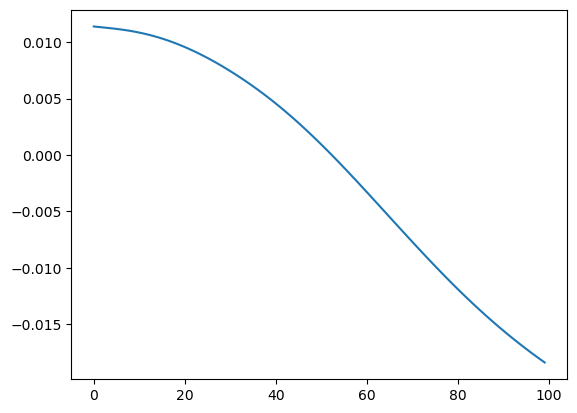

In [28]:
plt.plot(np.array(pinn.params_history["lame2"]).squeeze().tolist())
print(np.array(pinn.params_history["lame2"]).squeeze().tolist()[-20:])

In [88]:
results_dir="/home/arturosf/Documentos/repos/ElasticityPINN/examples/LinearProstata/results/3.1.2-new"
with open(f"{results_dir}/2000_logs.json","w") as f:
    json.dump(logs_E,f)


In [92]:
plt.style.use('default')

for E_str in E_options:
    E_real=float(E_str)
    aux_dict_E_inits=logs_E[E_str]
    fig,ax=plt.subplots()
    x1, x2, y1, y2 = -1, 400, E_real-0.05, E_real+0.05  # subregion of the original image
    axins = ax.inset_axes([0.3, 0.6, 0.67, 0.4],xlim=(x1, x2), ylim=(y1, y2))
    for i in E_inits:
        ax.plot(aux_dict_E_inits[str(i)]["E_value"],alpha=0.79,label=f"Init E value: {i}")
        ax.axhline(E_real,linestyle="-.",alpha=0.8,color="red",linewidth=0.3)
        ax.set_ylabel("E_init")
        ax.set_xlabel("Epochs")
        axins.plot(aux_dict_E_inits[str(i)]["E_value"])
        axins.axhline(E_real,linestyle="-.",alpha=0.7,color="red",linewidth=1)

    plt.title(f"E_true: {E_str}")
    ax.indicate_inset_zoom(axins, edgecolor="black")
    plt.tight_layout()
    plt.savefig(f"/home/arturosf/Documentos/repos/ElasticityPINN/examples/LinearProstata/results/3.1.2-new/{E_str}.png")
    plt.close()


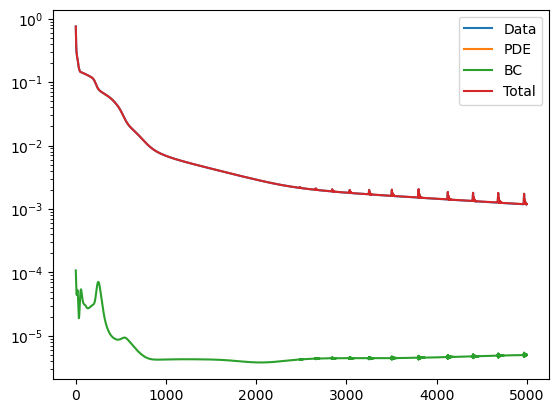

In [ ]:
plt.plot(pinn.loss_history["Data"], label='Data')
plt.plot(pinn.loss_history["PDE"], label='PDE')
plt.plot(pinn.loss_history["BC"], label='BC')
plt.plot(pinn.loss_history["Total"], label='Total')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig('PINN_LEP_Losses.png')

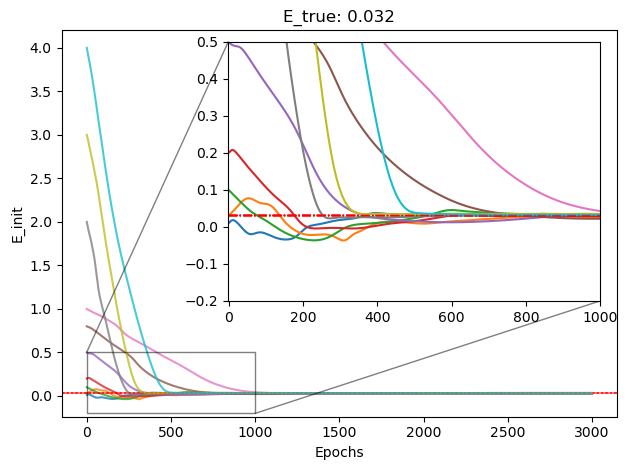

In [ ]:
plt.style.use('default')


fig,ax=plt.subplots()
x1, x2, y1, y2 = -1, 1000, -0.2, 0.5  # subregion of the original image
axins = ax.inset_axes(
[0.3, 0.3, 0.67, 0.67],
xlim=(x1, x2), ylim=(y1, y2), )
for i in E_inits[:-2]:
    ax.plot(dict_all_E[i],alpha=0.79,label=f"Init E value: {i}")
    ax.axhline(E_real,linestyle="-.",alpha=0.8,color="red",linewidth=0.3)
    ax.set_ylabel("E_init")
    ax.set_xlabel("Epochs")
    axins.plot(dict_all_E[i])
    axins.axhline(E_real,linestyle="-.",alpha=0.7,color="red",linewidth=1)

plt.title("E_true: 0.032")
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()


#plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

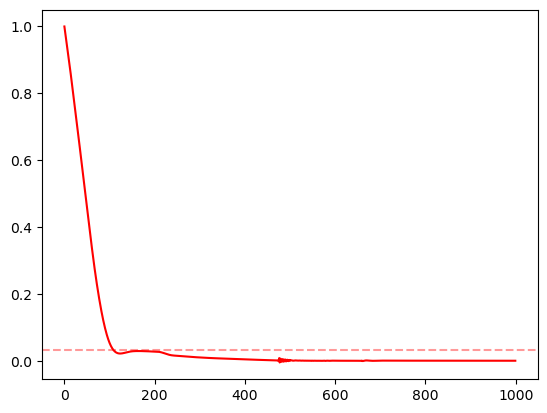

In [19]:
plt.plot(np.arange(epochs),pinn.params_history["E"],color="red",linestyle="-", label='E')
plt.axhline(E_real,color="red",linestyle="--",label='E_real',alpha=0.4)
plt.plot(np.arange(epochs),pinn.params_history["nu"],color="blue",linestyle="-", label='nu')
plt.axhline(nu_real,color="blue",linestyle="--",label='nu_real',alpha=0.4)


#plt.yscale('log')
plt.legend()
plt.show()
